In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnosti

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    #print("left or right image not receieved")
    time.sleep(0.5)
    
print("left or right image receieved")

left or right image receieved


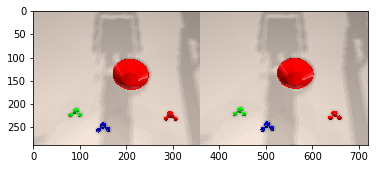

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 2779
  stamp: 
    secs: 1626237432
    nsecs: 244566679
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 2779
  stamp: 
    secs: 1626237432
    nsecs: 244566679
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  

In [6]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/home/iandre/dvrk_ws/src/geometry/tf/src/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM3_outer_pitch_back_link',
 'PSM3_outer_pitch_bottom_link',
 'PSM1_RCM',
 'PSM3_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_0',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'PSM2_outer_pitch_bottom_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM3_tool_wrist_link',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM2_RCM',
 'PSM2_tool_wrist_caudier_link',
 'PSM3_tool_wrist_caudier_link_2_right',
 'ecm_pitch_link_1',
 'ecm_pitch_link_2',
 'PSM3_tool_wrist_caudier_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_tool_wrist_caudier_link_2_left',
 'ecm_pitch_link_3',
 'PSM1_outer_pitch_top_link',
 'Vision_sensor_left',
 'simworld',
 'PSM2_tool_wrist_caudier_link_2_right',
 'ecm_base_link',
 'PSM1_tool_wrist_link',
 'PSM1_tool_main_link',
 'PSM3_tool_wrist_caudier_ee_link_0',
 'P

In [7]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, psm2, psm3, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')
    psm3 = dvrk.psm('PSM3')
    
    psm1_suj = dvrk.suj('PSM1')
    psm2_suj = dvrk.suj('PSM2')
    psm3_suj = dvrk.suj('PSM3')
    ecm_suj = dvrk.suj('ECM')
    
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm2.get_current_position() == PyKDL.Frame() or psm2.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm3.get_current_position() == PyKDL.Frame() or psm3.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [8]:
from math import radians as r

# 3 arm setup
#height, shoulder, elbow, wrist, rotate
# sm1 = [-0.0, -1.3, 1.9, -0.1, -0.8]  # right
# sm2 = [-0.0, 1.3, -1.8, -0.2, -0.8]  #  left
sm3 = [-0.0, 1.4, -1.8, -0.38, -0.7]  # middle
cm = [0.52, 0.95, -1.8, 0.8, 0.0]
time.sleep(1)

# psm1_suj.move_joint(np.asarray(sm1))
# psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

# print(psm1_suj.get_current_joint_position())
# print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
# print(psm1_suj.get_current_position())
# print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

[-0.          1.39999998 -1.79999995 -0.38       -0.69999999]
[ 0.51999998  0.94999999 -1.79999995  0.80000001]
----------------------------------
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[-1.50197e-06,      2.0009,      0.9163]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [9]:
# 3 arm setup
# ecm: rotate, up/down, zoom, rotate view
HARDCODED_ECM_POS = np.array([-0.00, -0.13, 0.15, 0.0])
PSM_HOME_POS = np.asarray([0.0, 0.2, 0.12, 0.0, 0.0, 0.0])

psm1.move_joint(deepcopy(PSM_HOME_POS))
psm1.close_jaw()
time.sleep(1)

# psm2.move_joint(deepcopy(PSM_HOME_POS))
# psm2.close_jaw()
# time.sleep(1)

# psm3.move_joint(deepcopy(PSM_HOME_POS))
# psm3.close_jaw()
# time.sleep(1)

ecm.move_joint(HARDCODED_ECM_POS)

True

In [10]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF, World
import image_geometry

time.sleep(1)

print(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

rot = PyKDL.Rotation.Quaternion(0.661155104637146, 0.7228261828422546, 0.14688998460769653, 0.13718444108963013)
pos2 = PyKDL.Vector(-1.0433012247085571, -0.02839038148522377, 1.2260448932647705)
tf_cam_to_world = PyKDL.Frame(rot, pos2)

# tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

# tf_world_to_psm1 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
# tf_world_to_psm2 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
tf_world_to_psm3 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

# tf_world_to_psm1_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))
# tf_world_to_psm1_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm1_j1

# tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time()))
# tf_world_to_psm2_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1

tf_world_to_psm3_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM3', 'simworld', rospy.Time()))
tf_world_to_psm3_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm3_j1

print(tf_cam_to_world)
print('----------------------------------')
print(tf_world_to_psm1_base)
print(tf_world_to_psm2_base)
print(tf_world_to_psm3_base)

([-1.0383386611938477, -0.02780972421169281, 1.262009859085083], [0.6508570313453674, 0.7117505669593811, 0.19353216886520386, 0.1798376888036728])
[[  -0.0881087,    0.915498,    0.392555;
     0.996102,   0.0825945,   0.0309515;
  -0.00408689,    0.393752,   -0.919208]
[     -1.0433,  -0.0283904,     1.22604]]
----------------------------------
[[    0.295464,     0.63096,     0.71735;
    -0.905729,    0.423858, 0.000240719;
    -0.303902,   -0.649795,    0.696713]
[   -0.412121,   -0.885098,    -1.32706]]
[[   -0.279526,    0.638178,   -0.717352;
    -0.916109,   -0.400929, 0.000295088;
    -0.287419,    0.657255,    0.696711]
[     0.48597,   -0.900659,    -1.25237]]
[[ -0.00533695,    0.944897,    0.327324;
    -0.999983, -0.00576148, 0.000327337;
   0.00219517,   -0.327317,    0.944912]
[    -0.29047,    -1.04558,    -1.21076]]


In [11]:
stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, 
                                          cam_to_world_tf=tf_cam_to_world)
world = World(objects)

print(world)

<World objects: [<Object3d pos: [   -0.979246,   0.0405265,     1.04361] type: FeatureType.BALL color: 2>, <Object3d pos: [    -0.97162,   -0.104373,     1.04199] type: FeatureType.BALL color: 0>, <Object3d pos: [   -0.994956, -0.00356303,     1.03541] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.02563,  -0.0448616,     1.04449] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.03305,   0.0158278,     1.04337] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.02647,  -0.0990452,     1.04231] type: FeatureType.BALL color: 0>]
bowl: <Object3d pos: [    -0.91511,  -0.0390317,     1.06832] type: FeatureType.BOWL color: 0>>


In [12]:
len(objects)

7

[    -0.91511,  -0.0390317,     1.06832]


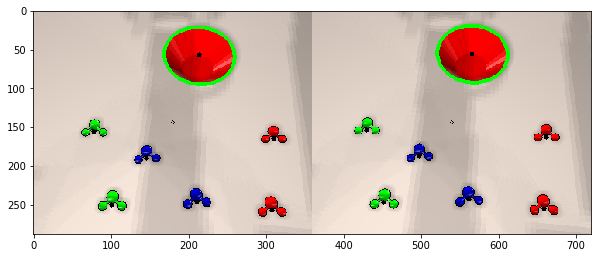

In [13]:
# bowl object position
bowl_pos_cam = objects[0].pos
print(bowl_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [14]:
from pick_and_place_arm_sm import PickAndPlaceStateMachine, PickAndPlaceState
from pick_and_place_three_arm_sm import PickAndPlaceThreeArmStateMachine
from pick_and_place_hsm import PickAndPlaceHSM
from pick_and_place_three_arm_hsm import PickAndPlaceThreeArmHSM
import IPython
from timeit import default_timer as timer
from pick_and_place_utils import get_objects_for_psms
from enum import Enum
the_image = IPython.display.Image(frame)

objects_to_pick = deepcopy(world.objects)

# this vector is empirically determined
approach_vec = PyKDL.Vector(0.000, -0.000, 0.002)

In [ ]:
# ========================================================================================================== 
# Runs PSM 3
# ========================================================================================================== 

VECTOR_EPS = 0.005

DOWN_JAW_ORIENTATION = PyKDL.Rotation.RPY(math.pi, 0, - math.pi / 2.0)

PSM_HOME_POS = PyKDL.Vector(0., 0., -0.1)

obj_dest = world.bowl.pos + PyKDL.Vector(0, 0, 0.05)

# open jaw
psm3.open_jaw()


In [ ]:
# approach object
dest = tf_world_to_psm3_base * objects[1].pos
psm3.move(PyKDL.Frame(DOWN_JAW_ORIENTATION, dest), blocking=False)

In [ ]:
# grab object
obj_pos = tf_world_to_psm3_base * objects[1].pos
app_vec = tf_world_to_psm3_base.M * approach_vec
dest = (obj_pos + app_vec)
psm3.move(PyKDL.Frame(DOWN_JAW_ORIENTATION, dest), blocking=False)

# close jaw
psm3.close_jaw()

# drop object

# home